In [33]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt
%matplotlib inline

In [17]:
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

In [30]:
# Define the dimensionality of our problem.
ndim = 1

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)

def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 10. * (2. * u - 1.)

In [31]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
results = sampler.results

# # "Dynamic" nested sampling.
# dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
# dsampler.run_nested()
# dresults = dsampler.results

1514it [00:00, 3087.03it/s, +500 | bound: 0 | nc: 1 | ncall: 9277 | eff(%): 21.710 | loglstar:   -inf < -0.919 <    inf | logz: -3.041 +/-  0.049 | dlogz:  0.001 >  0.509]


Quantiles:
$x_{1}$ [(0.025, -1.998095468211873), (0.5, 0.013641451641784944), (0.975, 2.0560648755156485)]


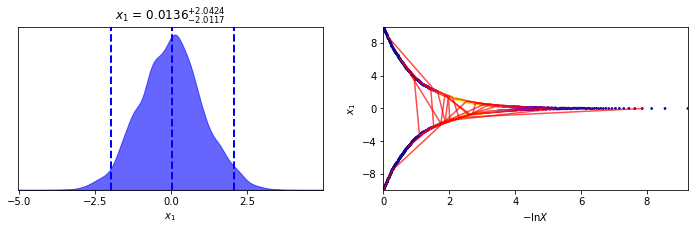

In [32]:
# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results, truth_color='black', show_titles=True, title_fmt='.4f',connect=True, verbose = True)

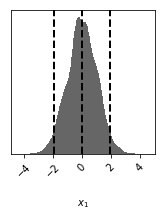

In [24]:
# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)

In [10]:
# Extract sampling results.
samples = results.samples  # samples
weights = np.exp(results.logwt - results.logz[-1])  # normalized weights

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(results)

In [11]:
print(sampler.citations)

Code and Methods:
Speagle (2019): ui.adsabs.harvard.edu/abs/2019arXiv190402180S

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944

Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:



In [36]:
dust_planck = hp.read_map('/fnx/jianyao/Likelihood_data/Planck_data/COM_CompMap_QU-thermaldust-commander_2048_R3.00_full.fits', field = (0,1),h = True)

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING


In [95]:
dust_planck[0]

array([[ 0.62278044, -0.60969543,  1.0043627 , ...,  1.57100761,
        -2.29446888,  1.75508893],
       [ 3.8357892 , -3.81855059,  4.50080633, ..., -0.79474467,
         0.49129763, -0.47606754]])

In [80]:
nmtlmax = 1000

In [81]:
bl = hp.gauss_beam(fwhm = 5.0/np.pi/180,lmax = 3*2048)

In [99]:
b1 = nmt.NmtBin(2048, nlb = 20, lmax = nmtlmax, is_Dell=True)

In [96]:
mask = np.ones(12*2048**2)
f2 = nmt.NmtField(mask, dust_planck[0]*c353, beam = bl)

In [100]:
cl_22 = nmt.compute_full_master(f2, f2, b1)

In [71]:
import pysm
from pysm.nominal import models
from pysm.common import convert_units

c353 = convert_units("uK_RJ", "uK_CMB", 353)

In [86]:
sky_config = {'dust' : models("d1", 512)}
sky = pysm.Sky(sky_config);

In [88]:
d353 = sky.dust(353)*c353

In [101]:
b2 = nmt.NmtBin(512, nlb = 20, lmax = nmtlmax, is_Dell=True)

In [102]:
f_pysm = nmt.NmtField(np.ones(12*512**2), d353[1:])
cl_pysm = nmt.compute_full_master(f_pysm, f_pysm, b2)

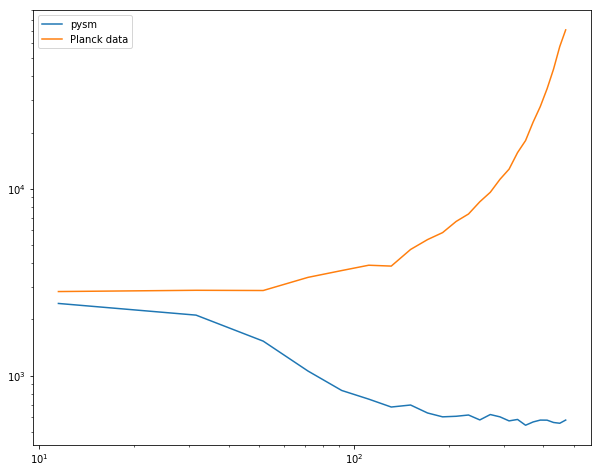

In [103]:
ell = b.get_effective_ells()

plt.figure(figsize = (10,8))
plt.loglog(ell, cl_pysm[3], label = 'pysm')
plt.loglog(ell, cl_22[3], label = 'Planck data')
plt.legend()